# OLCI Chlorophyll product comparison

    Version: 2.0
    Date:    10/04/2019
    Author:  Ben Loveday and Hayley Evers-King (Plymouth Marine Laboratory)
    Credit:  This code was developed for EUMETSAT under contracts for the Copernicus 
             programme.
    License: This code is offered as free-to-use in the public domain, with no warranty.

This aim of this code is to allow you to compare the standard CHL_OC4ME and complex water CHL_NN products over a given scene. It is recommended that you familiarise yourself with the OLCI_spatial_interrogation.ipynb code prior to using this.

In [1]:
%matplotlib inline

# libraries are imported here, and we can import any library with an alias that allows us easy access to them later.
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
warnings.filterwarnings('ignore')

In [2]:
land_resolution = '50m'
land_poly = cfeature.NaturalEarthFeature('physical', 'land', land_resolution,
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])

In [3]:
def flag_data_fast(flags_we_want, flag_names, flag_values, flag_data, flag_type='WQSF'):
    flag_bits = np.uint64()
    if flag_type == 'SST':
        flag_bits = np.uint8()
    elif flag_type == 'WQSF_lsb':
        flag_bits = np.uint32()
    
    for flag in flags_we_want:
        try:
            flag_bits = flag_bits | flag_values[flag_names.index(flag)]
        except:
            print(flag + " not present")
    
    return (flag_data & flag_bits) > 0

At Level-2 OLCI products contain two estimates of Chlorophyll pigment concentration. The first product, CHL_OC4ME, is the open-ocean pigment product, with retrievals based on reflectances derived from standard atmospheric processor. The second product, CHL_NN, is derived using a neural network approach this is more appropriate for complex waters. If you wish, you can derive the latter yourself in SNAP using the C2RCC processor. This may be beneficial to you, as this approach will also generate the Level-2 reflectances associated with this method, which are not included in the standard Level-2 product, as well as C2RCC flags. 

In [4]:
# e.g. MYPATH = os.path.join("C:/","Users","me","Desktop")
#MYPATH = "<please insert your path from Data_Path_Checker.ipynb here, removing the quotes and chevrons>"

MYPATH = os.path.join("C:\\","Users","docle","Desktop","autumn_2020_course-master")

In [5]:
input_root    = os.path.join(MYPATH,'OLCI_test_data')
input_path    = 'S3A_OL_2_WFR____20171226T045629_20171226T045929_20171227T105453_0179_026_076_2700_MAR_O_NT_002.SEN3'
file_name_chl_OC4ME = 'chl_oc4me.nc'
file_name_chl_NN = 'chl_nn.nc'
file_name_geo = 'geo_coordinates.nc'

We'll quickly check, in the next box, if your data path is ok, and that the data file exists check.

In [6]:
# quick path length check (some windows versions have a problem with long file paths)
if len(os.path.join(input_root,input_path,file_name_chl_OC4ME)) > 259 \
  or len(os.path.join(input_root,input_path,file_name_chl_OC4ME)) > 248:
    print('Beware, your path name is quite long. Consider moving your data to a new directory')
else:
    print('Path length name seems fine')
    
if os.path.exists(os.path.join(input_root,input_path,file_name_chl_OC4ME)):
    print('Found the required data file')
else:
    print('Data file missing. Please check your path and file name')

Path length name seems fine
Found the required data file


So, lets load in some data...

In [7]:
GEO_file = xr.open_dataset(os.path.join(input_root,input_path,file_name_geo))
LAT      = GEO_file.latitude
LON      = GEO_file.longitude
GEO_file.close()

OLCI_file_OC4ME  =  xr.open_dataset(os.path.join(input_root,input_path,file_name_chl_OC4ME))
OLCI_file_NN     =  xr.open_dataset(os.path.join(input_root,input_path,file_name_chl_NN))


print(OLCI_file_OC4ME.references)


CHL_OC4ME = OLCI_file_OC4ME.CHL_OC4ME.data
CHL_NN    = OLCI_file_NN.CHL_NN.data

OLCI_file_OC4ME.close()
OLCI_file_NN.close()

S3IPF PDS 004 - i2r1 - Product Data Format Specification - OLCI, S3IPF PDS 002 - i1r6 - Product Data Format Specification - Product Structures, S3IPF DPM 008 - i1r3 - Detailed Processing Model - OLCI Level 2


In [8]:
flags_we_want = ['CLOUD', 'CLOUD_AMBIGUOUS', 'CLOUD_MARGIN', 'INVALID', 'COSMETIC', 'SATURATED', 'SUSPECT',
                 'HISOLZEN', 'HIGHGLINT', 'SNOW_ICE', 'AC_FAIL', 'WHITECAPS', 'ANNOT_ABSO_D', 'ANNOT_MIXR1',
                 'ANNOT_DROUT', 'ANNOT_TAU06', 'RWNEG_O2', 'RWNEG_O3', 'RWNEG_O4', 'RWNEG_O5', 'RWNEG_O6',
                 'RWNEG_O7', 'RWNEG_O8']

file_name_flags = 'wqsf.nc'
FLAG_file = xr.open_dataset(os.path.join(input_root,input_path,file_name_flags))
# get all the flag names
flag_names = FLAG_file['WQSF'].flag_meanings.split(' ')
# get all the flag bit values
flag_vals = FLAG_file['WQSF'].flag_masks
# get the flag field itself
FLAGS = FLAG_file.variables['WQSF'].data
FLAG_file.close()

# make the flag mask using the function we defined above "flag_data_fast"
flag_mask = flag_data_fast(flags_we_want, flag_names, flag_vals, FLAGS, flag_type='WQSF')
flag_mask = flag_mask.astype(float)
flag_mask[flag_mask == 0.0] = np.nan

Lets flag our OC4ME data, and then calculate the anomaly between the two Chlorophyll products. 
REMEMBER: Not all of the standard L2 flags provided are relevant for the CHL_NN product.

In [9]:
CHL_OC4ME[np.isfinite(flag_mask)] = np.nan
CHL_NN[np.isfinite(flag_mask)] = np.nan

# the CHL values in the product are log10 distributed, so we have to linearise this prior to calculating the anomaly.
CHL_ANOMALY = 10**CHL_NN - 10**CHL_OC4ME

# now get the 95% percentile of the finite values of the array to help with plotting
MAX_VAL = np.percentile(np.abs(CHL_ANOMALY[np.isfinite(CHL_ANOMALY)]), 95)

In [10]:
CHL_ANOMALY

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

We have discussed plotting extensively in previous scripts, so here we will proceeed directly to plotting and comparing the data. We are plotting an ENTIRE full resolution scene, which can be processor intensive to display, so we are going to print directly to file

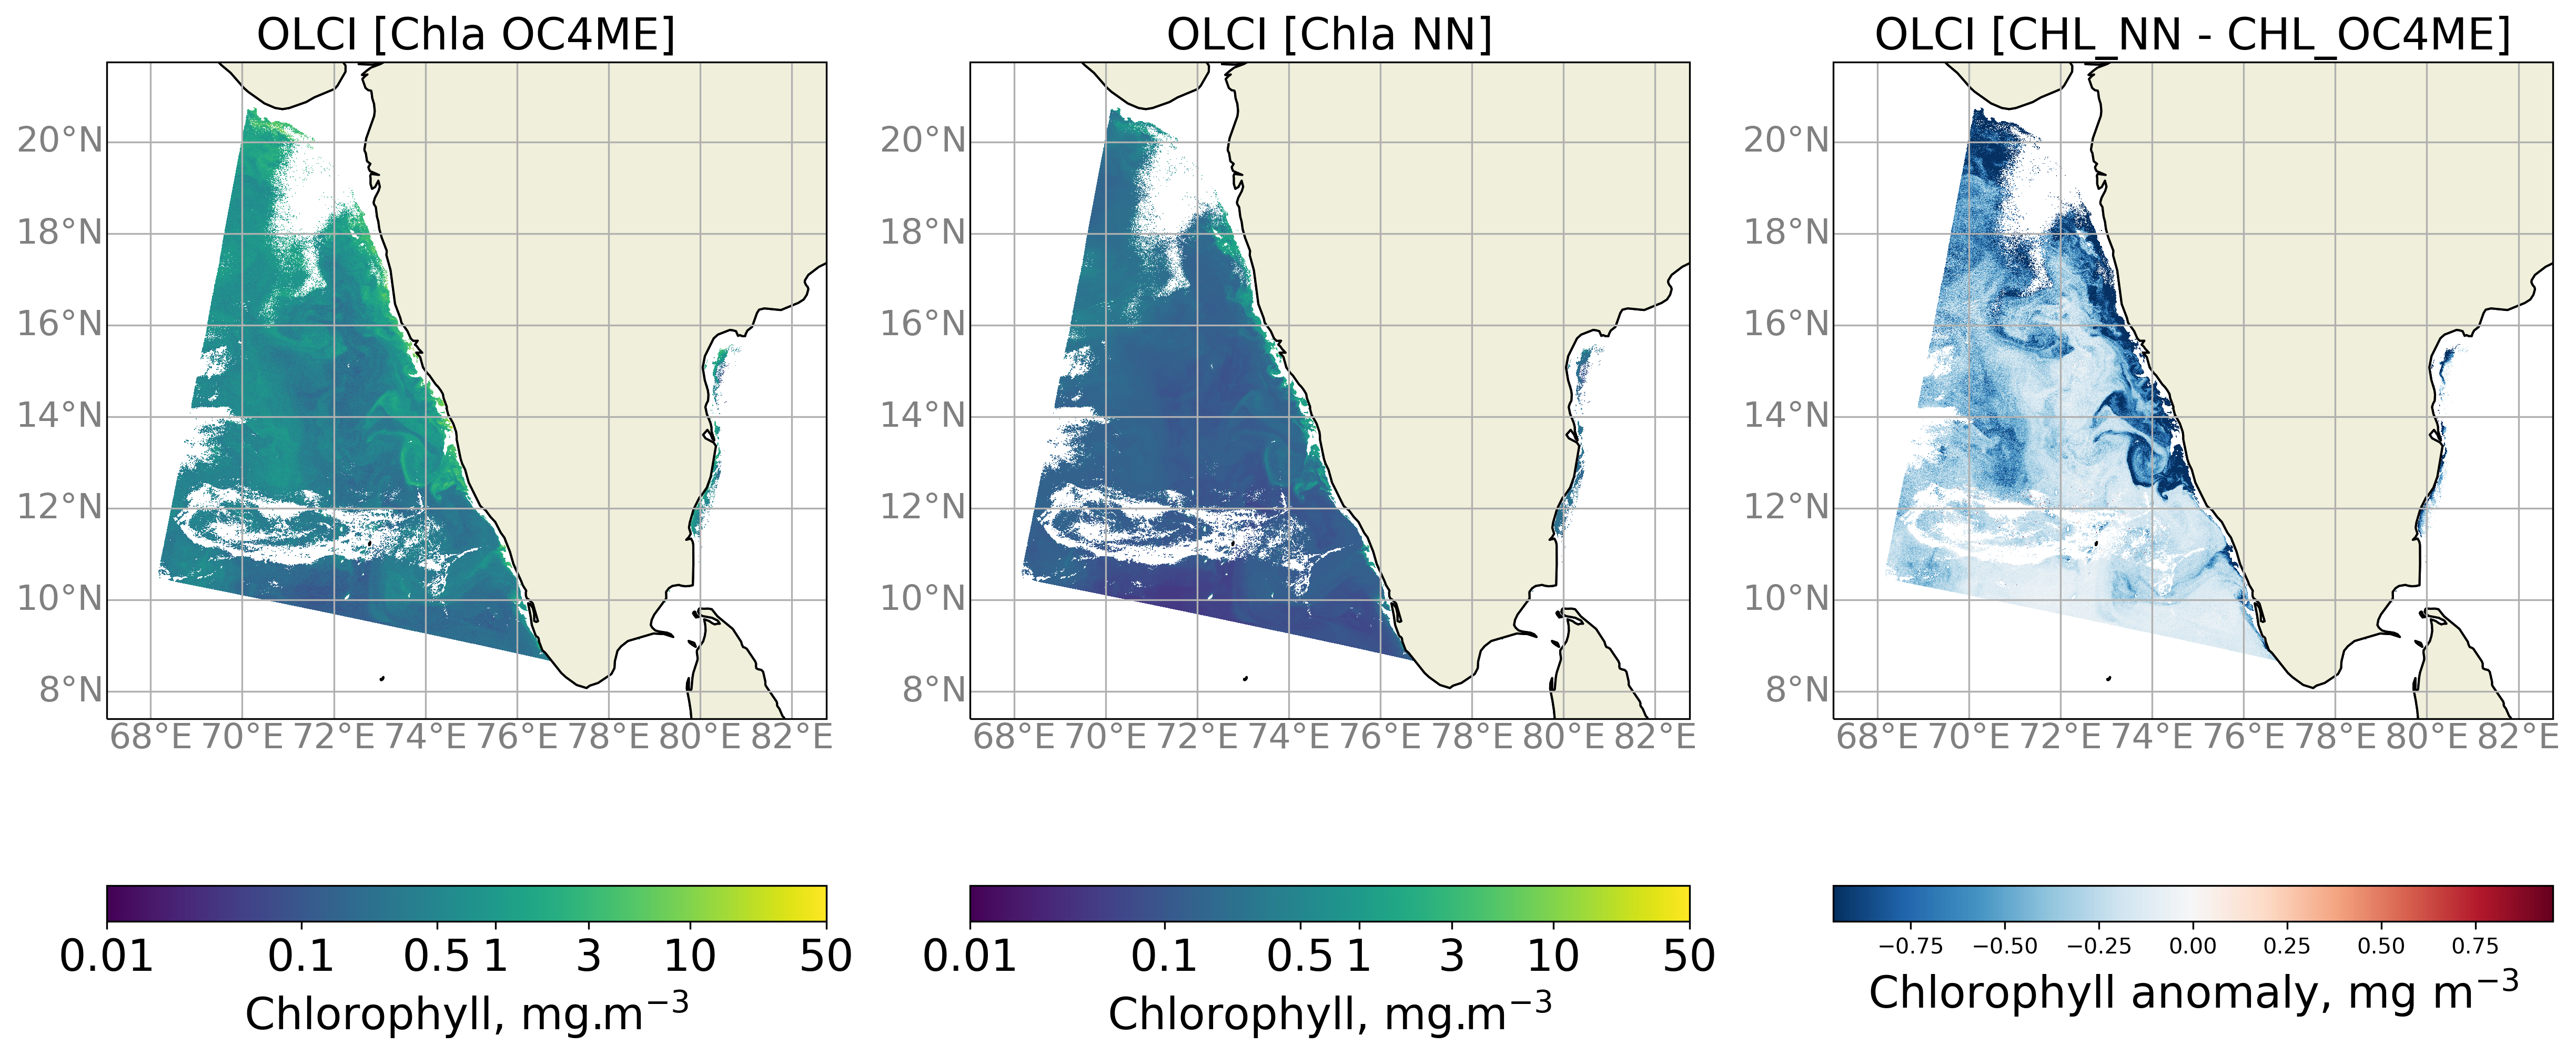

In [11]:
%matplotlib inline

fig1 = plt.figure(figsize=(20, 20), dpi=300)

gs  = gridspec.GridSpec(1, 3)

#plot OC4ME
m = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolormesh(LON, LAT, np.ma.masked_invalid(CHL_OC4ME), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg.m$^{-3}$', fontsize=20)
plt.title('OLCI [Chla OC4ME]', fontsize=20)

#plot NN
m = plt.subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolormesh(LON, LAT, np.ma.masked_invalid(CHL_NN), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07, ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg.m$^{-3}$', fontsize=20)
plt.title('OLCI [Chla NN]', fontsize=20)

#plot ANOMALY
m = plt.subplot(gs[0,2], projection=ccrs.PlateCarree(central_longitude=0.0))
f1 = plt.pcolormesh(LON, LAT, np.ma.masked_invalid(CHL_ANOMALY), shading='flat', vmin=MAX_VAL*-1, vmax=MAX_VAL, cmap=plt.cm.RdBu_r)
m.coastlines(resolution=land_resolution, color='black', linewidth=1)
m.add_feature(land_poly)
g1 = m.gridlines(draw_labels = True)
g1.xlabels_top = False
g1.ylabels_right = False
g1.xlabel_style = {'size': 16, 'color': 'gray'}
g1.ylabel_style = {'size': 16, 'color': 'gray'}
cbar = plt.colorbar(f1, orientation="horizontal", fraction=0.05, pad=0.07) 
cbar.set_label('Chlorophyll anomaly, mg m$^{-3}$', fontsize=20)
plt.title('OLCI [CHL_NN - CHL_OC4ME]', fontsize=20)

#fig1.savefig('OLCI_CHL_COMPARISON.png', bbox_inches='tight')

plt.show()

<br> <a href="./14_OLCI_water_constituents.ipynb"><< OLCI - Water constituents</a><span style="float:right;"><a href="./16_OLCI_spectral_AC_L1_L2_comparison.ipynb">16 - Ocean and Land Colour Instrument - atmospheric correction effects: Level-1B to Level-2 spectral comparison >></a>  <hr> <p style="text-align:left;">This project is licensed under the <a href="/edit/LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab-usc-open/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>